## Configuration

In [4]:
#IPython extension to reload modules before executing user code.
#'autoreload' reloads modules automatically before entering the execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import gpustat

#select the best free GPU on the nvidia card
stats = gpustat.GPUStatCollection.new_query()
ids = map(lambda gpu: int(gpu.entry['index']), stats)
ratios = map(lambda gpu: float(gpu.entry['memory.used'])/float(gpu.entry['memory.total']), stats)
bestGPU = min(zip(ids, ratios), key=lambda x: x[1])[0]
bestGPU = 3

print("setGPU: Setting GPU to: {}".format(bestGPU))
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = str(bestGPU)


#set memory usage to 0.5
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

setGPU: Setting GPU to: 3


In [ ]:
#!pip install -q keract 
import collections
import numpy
import mutual_info
from keract import get_activations, display_activations
import keras
from keras import backend as K
from keras import optimizers, regularizers
from keras.callbacks import LearningRateScheduler
from keras.datasets import cifar10 # we can use also cifar100
from keras.layers import Input, BatchNormalization, AveragePooling2D, ZeroPadding2D, LeakyReLU, GlobalAveragePooling2D, Dense, Flatten, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential, load_model, Model
from keras.regularizers import l2
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
import scipy
import sklearn
import sklearn.metrics
import time
from IPython.display import SVG

In [ ]:
# import of the models
import sys
sys.path.insert(0, "../")
from models import VGG16, VGG16_Vanilla, VGG16_beta,VGG16_Vanilla_beta
from data_utils import import_cifar

In [ ]:
# LOAD DATABase
num_classes = 10
(x_train, y_train), (x_test, y_test) = import_cifar(num_classes)

### Loading models

In [ ]:
# LOAD huge MODELS
modelB = VGG16_Vanilla_beta(input_shape=(32,32,3), num_classes=10) #without Weight Decay but batchNorm before activation
modelC = VGG16_beta(input_shape=(32,32,3), num_classes=10, weight_decay=0.005) #with Weight Decay, and batchNorm before activation
modelD = VGG16_Vanilla_beta(input_shape=(32,32,3), num_classes=10) #without Weight Decay, but batchNorm before activation and with layca
modelE = VGG16_Vanilla_beta(input_shape=(32,32,3), num_classes=10) #with layca but with a bad LR

modelB.load_weights("../weights/1/vgg16_vanilla_beta/final/weights-final.hdf5")
modelC.load_weights("../weights/1/vgg16_beta/final/weights-final.hdf5")
modelD.load_weights("../weights/1/vgg16_vanilla_layca/final/weights-final.hdf5")
modelE.load_weights("../weights/2/vgg16_vanilla_layca_bad/final/weights-final.hdf5")

sgd = optimizers.SGD(lr=0.2, momentum=0.9, nesterov=True)
modelB.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
modelC.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
modelD.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
modelE.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [ ]:
List_of_Layers = [[
'conv2d_1/BiasAdd:0', 
'conv2d_2/BiasAdd:0',
'max_pooling2d_1/MaxPool:0',
'conv2d_3/BiasAdd:0', 
'conv2d_4/BiasAdd:0', 
'max_pooling2d_2/MaxPool:0',
'conv2d_5/BiasAdd:0', 
'conv2d_6/BiasAdd:0',  
'conv2d_7/BiasAdd:0', 
'max_pooling2d_3/MaxPool:0', 
'conv2d_8/BiasAdd:0',  
'conv2d_9/BiasAdd:0', 
'conv2d_10/BiasAdd:0', 
'max_pooling2d_4/MaxPool:0', 
'conv2d_11/BiasAdd:0',    
'conv2d_12/BiasAdd:0',
'conv2d_13/BiasAdd:0', 
'max_pooling2d_5/MaxPool:0', 
'dense_1/BiasAdd:0', 
'dense_2/BiasAdd:0', 
 ], [
'conv2d_14/BiasAdd:0', 
'conv2d_15/BiasAdd:0',
'max_pooling2d_6/MaxPool:0',
'conv2d_16/BiasAdd:0', 
'conv2d_17/BiasAdd:0', 
'max_pooling2d_7/MaxPool:0',
'conv2d_18/BiasAdd:0', 
'conv2d_19/BiasAdd:0',  
'conv2d_20/BiasAdd:0', 
'max_pooling2d_8/MaxPool:0', 
'conv2d_21/BiasAdd:0',  
'conv2d_22/BiasAdd:0', 
'conv2d_23/BiasAdd:0', 
'max_pooling2d_9/MaxPool:0', 
'conv2d_24/BiasAdd:0',    
'conv2d_25/BiasAdd:0',
'conv2d_26/BiasAdd:0', 
'max_pooling2d_10/MaxPool:0', 
'dense_3/BiasAdd:0', 
'dense_4/BiasAdd:0', 
 ], [
'conv2d_27/BiasAdd:0', 
'conv2d_28/BiasAdd:0',
'max_pooling2d_11/MaxPool:0',
'conv2d_29/BiasAdd:0', 
'conv2d_30/BiasAdd:0', 
'max_pooling2d_12/MaxPool:0',
'conv2d_31/BiasAdd:0', 
'conv2d_32/BiasAdd:0',  
'conv2d_33/BiasAdd:0', 
'max_pooling2d_13/MaxPool:0', 
'conv2d_34/BiasAdd:0',  
'conv2d_35/BiasAdd:0', 
'conv2d_36/BiasAdd:0', 
'max_pooling2d_14/MaxPool:0', 
'conv2d_37/BiasAdd:0',    
'conv2d_38/BiasAdd:0',
'conv2d_39/BiasAdd:0', 
'max_pooling2d_15/MaxPool:0', 
'dense_5/BiasAdd:0', 
'dense_6/BiasAdd:0', 
 ], [
'conv2d_40/BiasAdd:0', 
'conv2d_41/BiasAdd:0',
'max_pooling2d_16/MaxPool:0',
'conv2d_42/BiasAdd:0', 
'conv2d_43/BiasAdd:0', 
'max_pooling2d_17/MaxPool:0',
'conv2d_44/BiasAdd:0', 
'conv2d_45/BiasAdd:0',  
'conv2d_46/BiasAdd:0', 
'max_pooling2d_18/MaxPool:0', 
'conv2d_47/BiasAdd:0',  
'conv2d_48/BiasAdd:0', 
'conv2d_49/BiasAdd:0', 
'max_pooling2d_19/MaxPool:0', 
'conv2d_50/BiasAdd:0',    
'conv2d_51/BiasAdd:0',
'conv2d_52/BiasAdd:0', 
'max_pooling2d_20/MaxPool:0', 
'dense_7/BiasAdd:0', 
'dense_8/BiasAdd:0', 
 ]]

In [ ]:
# EVALUATION
# Final evaluation of the models
scoresB = modelB.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scoresB[0])
print('Test accuracy:', scoresB[1])
print("%.2f%% : Model B without Weightdecay with BatchNorm before activation CNN Error" % (100-scoresB[1]*100))
scoresC = modelC.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scoresC[0])
print('Test accuracy:', scoresC[1])
print("%.2f%% : Model C with Weightdecay Error" % (100-scoresC[1]*100))
scoresD = modelD.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scoresD[0])
print('Test accuracy:', scoresD[1])
print("%.2f%% : Model D with layca Error"  % (100-scoresD[1]*100))
scoresE = modelE.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scoresE[0])
print('Test accuracy:', scoresE[1])
print("%.2f%% : Model E with layca with bad LR Error" % (100-scoresE[1]*100))

### Mutual Information
On regarde l'information mutuelle arrondie à des binaires.

In [ ]:
# On regarde l'activation des pairs de neurones pour un echantillon test pris au hasard
Echantillon = []
nombreDImagesDActivation = 50
NombrePairs = 1000#0
choix = numpy.random.choice(x_test.shape[0], nombreDImagesDActivation)
Echantillon = x_test[choix, :, : , :]

#Echantillon = [x_test[0], x_test[1], x_test[2], x_test[3], x_test[4], x_test[5], x_test[6], x_test[7], x_test[8], x_test[9], x_test[10], x_test[11], x_test[12], x_test[13]]
IMB = get_activations(modelB, Echantillon)
IMC = get_activations(modelC, Echantillon)
IMD = get_activations(modelD, Echantillon)
IME = get_activations(modelE, Echantillon)
# on affiche les noms des differentes couches
#print(IMA.keys())
#modelA.summary()

In [ ]:
def MI():
    M = []
    number_of_models = 4
    for i in range(number_of_models):
        for layer in List_of_Layers[i]:
            print(layer)
            print(i)
    '''
    #count of the number of MI = 1
    CountMI1 = 0
    #count the number of pathologic neurons (only 1 or 0)
    pathologicCount = 0
    pathologicCount_00 = 0
    pathologicCount_01 = 0
    pathologicCount_11 = 0
    MutualInfoWithoutOnes = []
    
    #nombre d'images utilisées pour l'activation:
    numActivations = len(IM[nameOfTheLayer])
    
    #nombre de neurones dans la couche
    #numNeurons = len(IM[nameOfTheLayer][0])
    numNeurons = numpy.size(IM[nameOfTheLayer][0])
    print('number of neurons for the layer: '+str(numNeurons))

    #print(IM[nameOfTheLayer])
    #plt.imshow(IM[nameOfTheLayer])
    #plt.show()
    
    
    # on selectionne des pair de neurones (X,Y) à comparer (regarder l'information mutuelle entre X et Y)
    NeuronsSelected = numpy.zeros((NombrePairs,2))  # initialize

    for i in range(NombrePairs):
        NeuronsSelected[i] = numpy.ceil(numpy.random.rand(2)*numNeurons)  # on prend 2 neurones selectionnées aleatoirement
        # les 2 neurones doivent être différents
        while NeuronsSelected[i][0] == NeuronsSelected[i][1]:
            NeuronsSelected[i] = numpy.ceil(numpy.random.rand(2)*numNeurons)

    #print(NeuronsSelected[56])
    #print(NeuronsSelected[56][0])
    
    MutualInfo = numpy.zeros((NombrePairs,1))  # initialization des resultats

    for j in range(NombrePairs):
        X = numpy.zeros((numActivations,1))  # initialization du vecteur X
        Y = numpy.zeros((numActivations,1))  # initialization du vecteur y

        i = 0
        for activation in IM[nameOfTheLayer]:   # pour chaque element de l'echantillon (= chaque activation)
            #print(activation)
            #print(numpy.size(activation))
            activation = activation.flatten()
            #print(activation)
            
            #on normalise les acrtivations
            NormedActivation = activation / numpy.linalg.norm(activation)
            
            X[i] = NormedActivation[int(NeuronsSelected[j][0])-1] # on regarde l'activation du neurone selectionné
            Y[i] = NormedActivation[int(NeuronsSelected[j][1])-1]
            
            # on binarise a la moyenne des activations:
            Val_Binarization_X = numpy.mean(X)
            Val_Binarization_Y = numpy.mean(Y)
            
            
            if X[i] > Val_Binarization_X:
                X[i] = 1
            else:
                X[i] = 0
            if Y[i] > Val_Binarization_Y:
                Y[i] = 1
            else:
                Y[i] = 0

            i = i+1

        X = X.flatten()
        Y = Y.flatten()
        print(entropy(X))
        print(entropy(Y))

        # example:= sklearn.metrics.normalized_mutual_info_score([1.1,1.0,1.0,1.0,0.0],[1.1,0.1,0.1,1.1,0.1])
        MutualInfo[j] = sklearn.metrics.normalized_mutual_info_score(X,Y,average_method='max')
        #print(MutualInfo[j])
        
        # on capte les neurones pathologiques
        if (MutualInfo[j])==1.:
            CountMI1 = CountMI1 + 1
            if all([ v == 0 for v in X ]) and all([ v == 0 for v in Y ]):
                pathologicCount = pathologicCount + 1
                pathologicCount_00 = pathologicCount_00 + 1
            elif all([ v == 1 for v in X ]) and all([ v == 1 for v in Y ]):
                pathologicCount = pathologicCount + 1
                pathologicCount_11 = pathologicCount_11 + 1
            elif all([ v == 0 for v in X ]) and all([ v == 1 for v in Y ]):
                pathologicCount = pathologicCount + 1
                pathologicCount_01 = pathologicCount_01 + 1
            elif all([ v == 1 for v in X ]) and all([ v == 0 for v in Y ]):
                pathologicCount = pathologicCount + 1
                pathologicCount_01 = pathologicCount_01 + 1
        else:
            MutualInfoWithoutOnes.append(MutualInfo[j])
            
    return MutualInfo, MutualInfoWithoutOnes, CountMI1, pathologicCount, pathologicCount_00, pathologicCount_11, pathologicCount_01
    '''
    return M        


In [ ]:
MI(IME)

In [77]:
# initialization of variables for the plots
MIMeanE = []
MI_1MeanE = []
PCountE = []
PCountE_0 = []
PCountE_1 = []
PCountE_M = []
VarPathE = []

number of images used for see the activations : 50

number of pairs of neurons analyzed: 1000

 Model E :

couche : conv2d_40/BiasAdd:0
number of neurons for the layer: 65536


NameError: name 'nearest_distances' is not defined

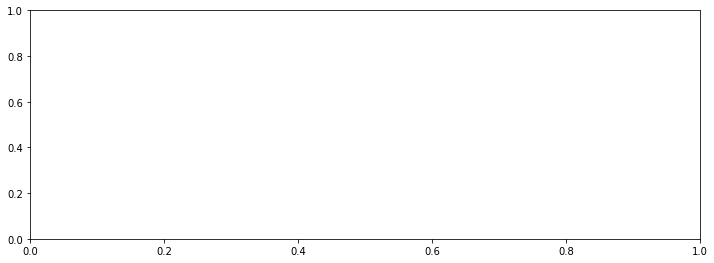

In [78]:
print('number of images used for see the activations : '+str(nombreDImagesDActivation) + '\n')
print('number of pairs of neurons analyzed: '+str(NombrePairs))

fig = plt.figure(figsize=(12, 100))
i = 1
print('\n Model E :\n')
for layer in List_of_Layers_E:
    plt.subplot(len(List_of_Layers_E), 1 ,i)
    #nom de la couche
    print('couche :', str(layer))
    #MI
    MutualInfo, MutualInfoWithoutOnes, CountMI1, pathologicCount, pathologicCount_00, pathologicCount_11, pathologicCount_01 = MI(IME, layer)
    MIMeanE.append(numpy.mean(MutualInfo))
    MI_1MeanE.append(numpy.mean(MutualInfoWithoutOnes))
    PCountE.append(pathologicCount)
    PCountE_0.append(pathologicCount_00)
    PCountE_1.append(pathologicCount_11)
    PCountE_M.append(pathologicCount_01)
    #plot
    plt.hist(MutualInfo, range = (0, 1.001), bins = 100, color = 'yellow',
            edgecolor = 'red')
    plt.xlabel('Mutual Information')
    plt.ylabel('Occurence')
    plt.title('\n Occurence de la mutual information de '+str(nombreDImagesDActivation)+' images d\'activation\n Sur '+str(NombrePairs)+' pairs de neurones pris aléatoirement\n sur la couche: '+ str(layer)+' du modele A : without WD')
    plt.tight_layout()
    plt.ylim(top=NombrePairs)
    plt.axvline(x=MIMeanE[-1], color='red')
    plt.axvline(x=MI_1MeanE[-1], color='blue')
    print('MI mean: ', str(MIMeanE[-1]))
    print('MI without_1 mean: ', str(MI_1MeanE[-1]))
    print('pathologic pair Count: ', str(pathologicCount),' on ',str(NombrePairs),' pairs = ',str(pathologicCount/NombrePairs*100),'%')
    print('pathologic pair Count: ', str(pathologicCount),'->  pathologic Count 0: ',str(pathologicCount_00),'  pathologic Count 1: ',str(pathologicCount_11),'  pathologic Count mix: ', str(pathologicCount_01))
    if CountMI1 != 0:
        VarPathE.append(pathologicCount/CountMI1)
    else:
        VarPathE.append(0)
    print('pathologic pair Count: ', str(pathologicCount),' on ',str(CountMI1),' MI1 = ',str(VarPathE[-1]*100),'%')
    print('\n')
    i = i+1
plt.show()